In [35]:
import sys

sys.path.append('..')

In [36]:
import torch

data = torch.load('../processed_data/complete_dataset/processed_data.pt')
label = torch.load('../processed_data/complete_dataset/processed_label.pt')

In [37]:
from audio_toolbox.metrics import audio_dataset_split

RANDOM_STATE = 42
X_train, y_train, _, _,\
X_test, y_test = audio_dataset_split(data, label, train_val_test_ratio=(0.9, 0, 0.1), random_state=RANDOM_STATE)

In [29]:
import numpy as np
from sklearn.decomposition import PCA

X_train_channel_flattened = X_train.reshape(X_train.shape[0], 6, -1)
X_test_channel_flattened = X_test.reshape(X_test.shape[0], 6, -1)

pca_results_train, pca_results_test = [], []

# Perform PCA on each channel
for channel in range(X_train_channel_flattened.shape[1]):
    channel_data_train = X_train_channel_flattened[:, channel, :]
    channel_data_test = X_test_channel_flattened[:, channel, :]

    pca = PCA(n_components=0.9)

    pca_transformed_data_train = pca.fit_transform(channel_data_train)
    print(f"Channel {channel}: remaining {pca_transformed_data_train.shape} features")
    pca_transformed_data_test = pca.transform(channel_data_test)

    pca_results_train.append(pca_transformed_data_train)
    pca_results_test.append(pca_transformed_data_test)


reduced_X_train_flat = np.hstack(pca_results_train)
reduced_X_test_flat = np.hstack(pca_results_test)

Channel 0: remaining (899, 189) features
Channel 1: remaining (899, 419) features
Channel 3: remaining (899, 602) features
Channel 4: remaining (899, 603) features


In [38]:
X_train_flat = X_train.view(X_train.shape[0], -1).cpu().numpy()
X_test_flat = X_test.view(X_test.shape[0], -1).cpu().numpy()

Do PCA on flattened features

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize the scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components=0.9) # Keep 90% of the variance

# Fit the scaler on the training set and transform all sets
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

reduced_X_train_flat = pca.fit_transform(X_train_scaled)
reduced_X_test_flat = pca.transform(X_test_scaled)

In [40]:
X_train = X_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_train = y_train.cpu().numpy()
y_test = y_test.cpu().numpy()

In [41]:
print(f"Training samples: {X_train.shape} -> {reduced_X_train_flat.shape}")
print(f"Test samples: {X_test.shape} -> {reduced_X_test_flat.shape}")

Training samples: (899, 6, 12, 1290) -> (899, 661)
Test samples: (100, 6, 12, 1290) -> (100, 661)


Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 60.0000%, 40 mismatches out of 100 samples
(Averaged) Test precision: 0.6015, recall: 0.6275, f1 score: 0.5812


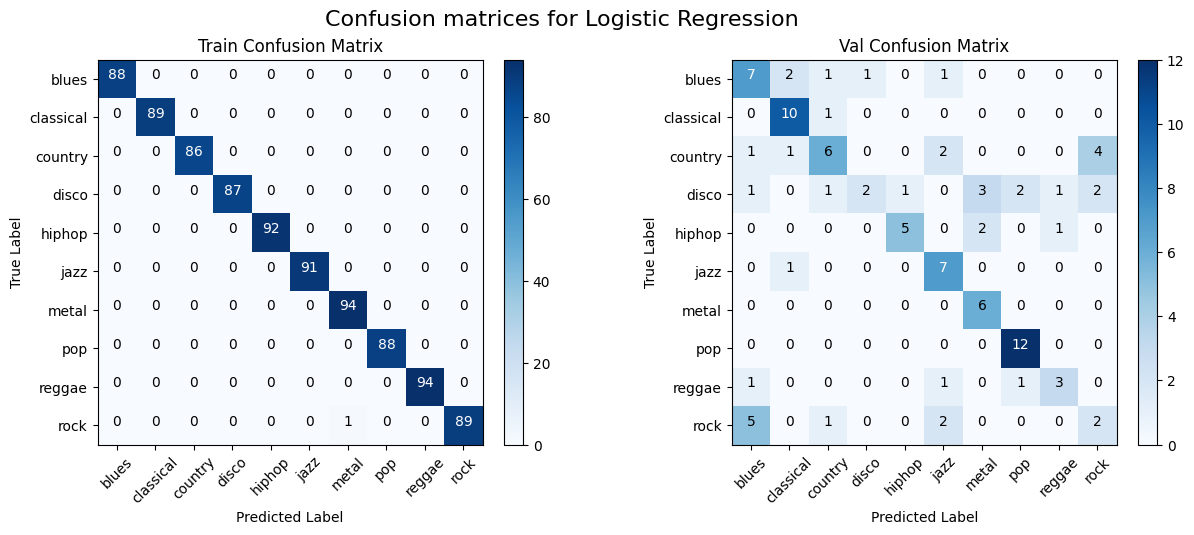

In [43]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from audio_toolbox.metrics import calculate_acc, precision_recall, visualize_confusion_matrices

logistic_model = LogisticRegression(max_iter=1000, C=1e-3, random_state=RANDOM_STATE)
logistic_model.fit(reduced_X_train_flat, y_train)
print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(logistic_model, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(logistic_model, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             ('Train', 'Val'),
                             'Confusion matrices for Logistic Regression')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 52.0000%, 48 mismatches out of 100 samples
(Averaged) Test precision: 0.5231, recall: 0.5442, f1 score: 0.5121


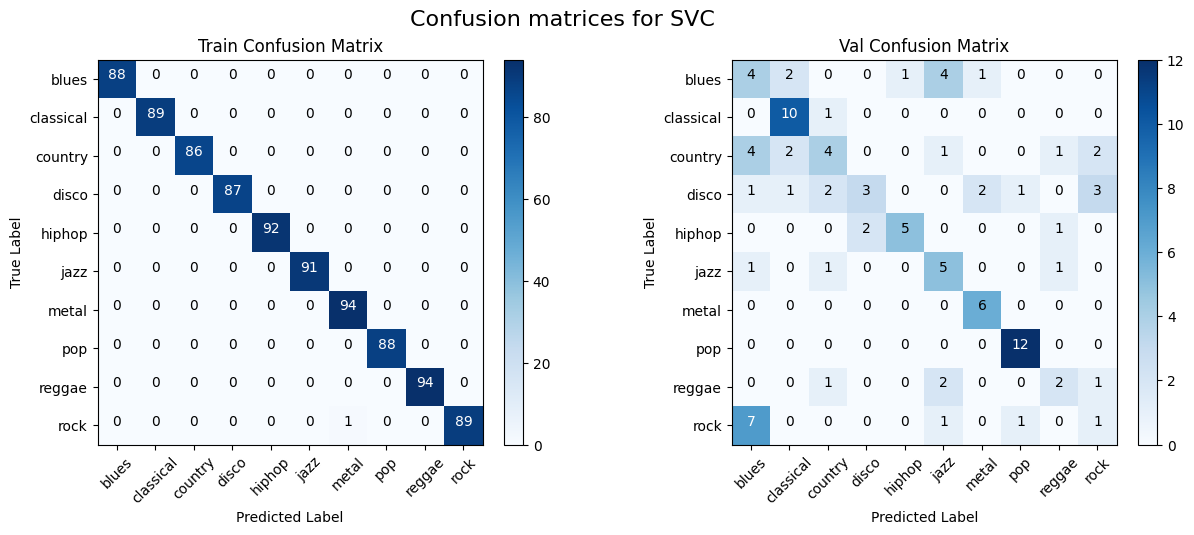

In [21]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', C=2, random_state=RANDOM_STATE)
svm_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(svm_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(svm_classifier, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             ('Train', 'Val'),
                             'Confusion matrices for SVC')

In [22]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(n_estimators=100,
                                                max_depth=3,
                                                random_state=RANDOM_STATE)
rand_forest_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

conf_mats = []
for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(rand_forest_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(rand_forest_classifier, x, y, return_each_class=False)
    conf_mats.append(conf_mat)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
    
visualize_confusion_matrices(conf_mats,
                             ('Train', 'Val'),
                             'Confusion matrices for SVC')

Model fitting finished
Train accuracy: 69.6329%, 273 mismatches out of 899 samples
(Averaged) Train precision: 0.7710, recall: 0.6921, f1 score: 0.6812
Test accuracy: 30.0000%, 70 mismatches out of 100 samples
(Averaged) Test precision: 0.4486, recall: 0.3601, f1 score: 0.2491


Model fitting finished
Train accuracy: 83.2036%, 151 mismatches out of 899 samples
(Averaged) Train precision: 0.8446, recall: 0.8304, f1 score: 0.8311
Test accuracy: 27.0000%, 73 mismatches out of 100 samples
(Averaged) Test precision: 0.2973, recall: 0.3142, f1 score: 0.1790


In [23]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([X_train_flat, X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(gnb_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

NameError: name 'X_train_flat' is not defined

In [24]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
gnb_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(gnb_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 71.7464%, 254 mismatches out of 899 samples
(Averaged) Train precision: 0.7450, recall: 0.7175, f1 score: 0.7206
Test accuracy: 20.0000%, 80 mismatches out of 100 samples
(Averaged) Test precision: 0.2661, recall: 0.1951, f1 score: 0.1417


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost_classifier = GradientBoostingClassifier(subsample=0.8, max_depth=2, random_state=RANDOM_STATE)
xgboost_classifier.fit(reduced_X_train_flat, y_train)

print('Model fitting finished')

for x, y, split in zip([reduced_X_train_flat, reduced_X_test_flat],
                [y_train, y_test],
                ['Train', 'Test']):
    acc, correct, incorrect = calculate_acc(xgboost_classifier, x, y)
    print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
    conf_mat, precision, recall, f1 = precision_recall(gnb_classifier, x, y, return_each_class=False)
    print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')

Model fitting finished
Train accuracy: 99.6663%, 3 mismatches out of 899 samples
(Averaged) Train precision: 0.6591, recall: 0.5800, f1 score: 0.5631
Test accuracy: 44.0000%, 56 mismatches out of 100 samples
(Averaged) Test precision: 0.4229, recall: 0.1250, f1 score: 0.0650


Prepare dataset for K fold 

In [15]:
data_flat = data.view(data.shape[0], -1).cpu().numpy()
data_scaled = scaler.fit_transform(data_flat)
reduced_data = pca.fit_transform(data_scaled)

In [26]:
#Training xgboost classifier takes more time. For quick testing, feel free to delete it from the list
#current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier, xgboost_classifier] 
current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier]
#current_model_names = ["logistic", "svm", "ovo_svm", "rand_forest_classifier", "gnb_classifier", "xgboost_classifier"]
current_model_names = ["logistic", "svm", "ovo_svm", "rand_forest_classifier", "gnb_classifier"]

In [27]:
from audio_toolbox.metrics import kfold_validation

N_SPLITS = 5

accs = {}

for model, name in zip(current_models, current_model_names):
    print(f"Benchmarking {name}")
    avg_acc, avg_precision, avg_recall, avg_f1 = kfold_validation(model, reduced_data, label, n_splits=N_SPLITS)
    accs[name] = avg_acc
    print(f"Average Accuracy: {avg_acc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("\n")


Benchmarking logistic
Average Accuracy: 46.3467
Average Precision: 0.8953
Average Recall: 0.8921
Average F1 Score: 0.8921


Benchmarking svm
Average Accuracy: 43.4387
Average Precision: 0.7058
Average Recall: 0.6863
Average F1 Score: 0.6511


Benchmarking ovo_svm
Average Accuracy: 56.2518
Average Precision: 0.9039
Average Recall: 0.9017
Average F1 Score: 0.9013


Benchmarking rand_forest_classifier
Average Accuracy: 43.0417
Average Precision: 0.8019
Average Recall: 0.7877
Average F1 Score: 0.7858


Benchmarking gnb_classifier
Average Accuracy: 35.2352
Average Precision: 0.6438
Average Recall: 0.5602
Average F1 Score: 0.5436




In [38]:
import matplotlib.pyplot as plt
import numpy as np
def create_bar_chart(data, title, ylabel):
    models = list(data.keys())
    scores = list(data.values())
    fig, ax = plt.subplots()
    bar_positions = np.arange(len(models))
    ax.bar(bar_positions, scores, color='skyblue')
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

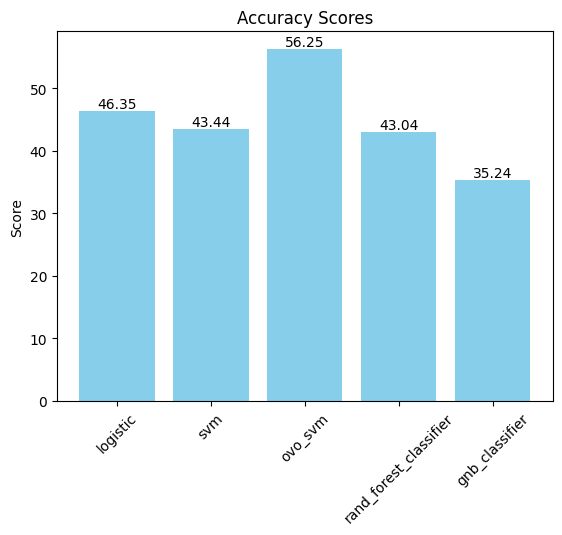

In [39]:
create_bar_chart(accs, "Accuracy Scores", "Score")